In [ ]:
# pip install selenium

In [9]:
import time
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service as ChromeService
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.keys import Keys
from webdriver_manager.chrome import ChromeDriverManager

In [ ]:
service = ChromeService(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service)

# URL 접근
base_url = 'https://youtube-rank.com/board/bbs/board.php?bo_table=youtube&page='

# 데이터 저장 리스트
data = []

# 페이지 순회 (1~10페이지)
for page in range(1, 11):
    # 페이지 이동
    url = f"{base_url}{page}"
    driver.get(url)
    print(f"페이지 {page} 처리 중...")
    time.sleep(1) 

    # 스크롤 반복 및 데이터 수집
    for _ in range(16): 
        rows = driver.find_elements(By.XPATH, '//tr')
        for row in rows:
            try:
                # 태그 확인하고 데이터 추출하기
                category = row.find_element(By.XPATH, './td[3]/h1/p').text  # 카테고리
                title = row.find_element(By.XPATH, './td[3]/h1/a').text  # 제목
                subscriber_cnt = row.find_element(By.XPATH, './td[4]').text  # 구독자수
                view_cnt = row.find_element(By.XPATH, './td[5]').text  # 조회수
                video_cnt = row.find_element(By.XPATH, './td[6]').text  # 비디오수

                # 중복 데이터 방지
                if not any(d['제목'] == title for d in data):
                    data.append({
                        '페이지': page,
                        '카테고리': category,
                        '제목': title,
                        '구독자수': subscriber_cnt,
                        '조회수': view_cnt,
                        '비디오수': video_cnt
                    })
            except Exception as e:
                # 비어 있는 행 스킵
                print(f"Error processing row: {e}")

        # PAGE_DOWN 키로 스크롤
        driver.find_element(By.TAG_NAME, 'body').send_keys(Keys.PAGE_DOWN)
        time.sleep(1)  # 데이터 로드 대기

# 브라우저 종료
driver.quit()

In [16]:
# 데이터 확인 
df = pd.DataFrame(data)
df

,페이지,카테고리,제목,구독자수,조회수,비디오수
0,1,[음악/댄스/가수],BLACKPINK,9570만,378억7825만,603개
1,1,[BJ/인물/연예인],김프로KIMPRO,8350만,522억9923만,"2,944개"
2,1,[음악/댄스/가수],BANGTANTV,7970만,244억0527만,"2,693개"
3,1,[음악/댄스/가수],HYBE LABELS,7650만,378억6932만,"2,283개"
4,1,,,,,
...,...,...,...,...,...,...
993,10,[미분류],BANDAI NAMCO Europe,92만,4억5538만,"4,435개"
994,10,[패션/미용],도영도영이,92만,9712만,279개
995,10,[미분류],재훍 영상툰,92만,5억2926만,347개
996,10,[음악/댄스/가수],Healing Meditation,92만,1억3446만,563개


In [17]:
# 추출 데이터 저장 
df.to_csv('youtube_rank.csv', index=False, encoding='utf-8-sig')

In [54]:
import pandas as pd 
import matplotlib.pyplot as plt 
import plotly.express as px
import matplotlib as mpl 
mpl.rcParams['axes.unicode_minus'] = False
plt.rc('font',family='Malgun Gothic')

import warnings
warnings.filterwarnings('ignore',category=FutureWarning)

#### 유튜브 카테고리 별 분포

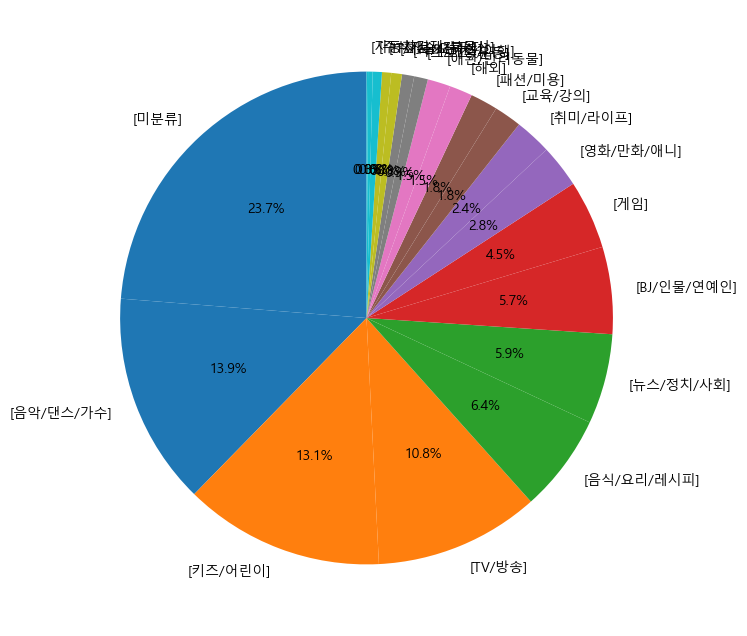

In [33]:
category_count = df['카테고리'].value_counts()
plt.figure(figsize=(10,8))
category_count.plot.pie(autopct='%1.1f%%', startangle=90, cmap='tab10', ylabel='')
plt.show()

#### 카테고리 별 구독자 수 분포

In [ ]:
# 형변환  
def convert_to_int(value):
    if pd.isna(value) or (isinstance(value, str) and value.strip() == ''):
        return 0
    try:
        if isinstance(value, str):
            if '억' in value:
                value = value.replace('억', '').strip()
                value = int(float(value) * 100000000)
            elif '만' in value:
                value = value.replace('만', '').strip()
                value = int(float(value) * 10000)
            else:
                value = int(value)
        else:
            value = int(value)
    except ValueError:
        return 0
    return value

df['구독자수'] = df['구독자수'].apply(convert_to_int)
df['조회수'] = df['조회수'].apply(convert_to_int)
df['비디오수'] = df['비디오수'].apply(convert_to_int)
# df.head(5) 

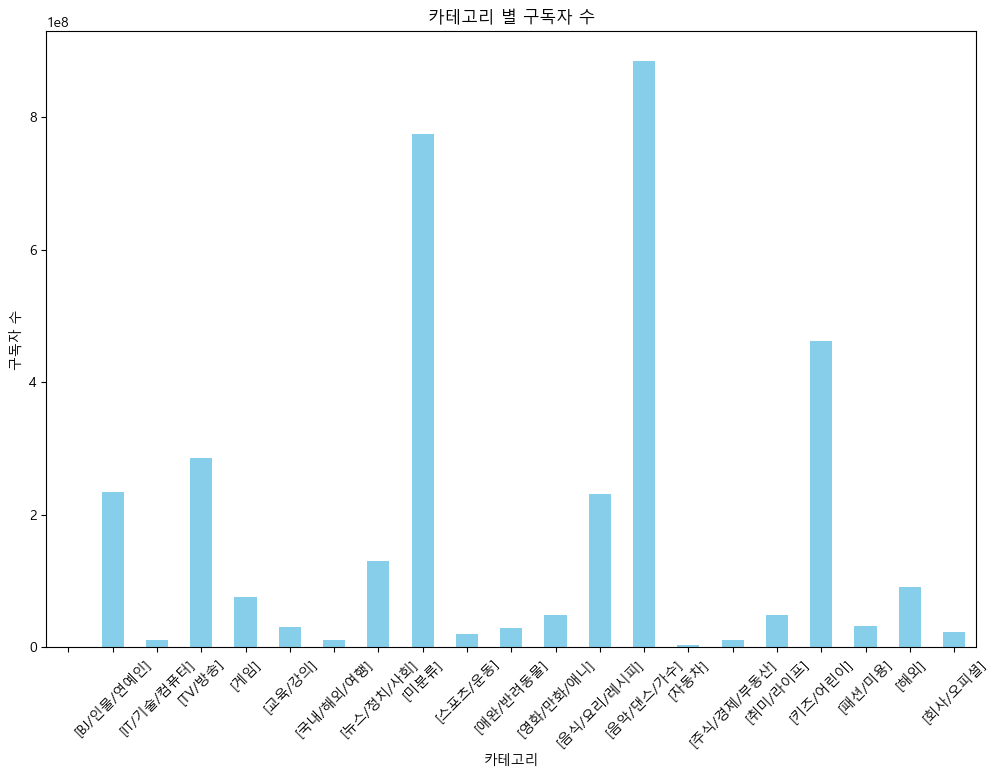

In [53]:
category_subscriber_count = df.groupby('카테고리')['구독자수'].sum()


plt.figure(figsize=(12, 8))
category_subscriber_count.plot(kind='bar', color='skyblue')
plt.title('카테고리 별 구독자 수')
plt.xlabel('카테고리')
plt.ylabel('구독자 수')
plt.xticks(rotation=45)
plt.show()

#### 카테고리 별 조회수

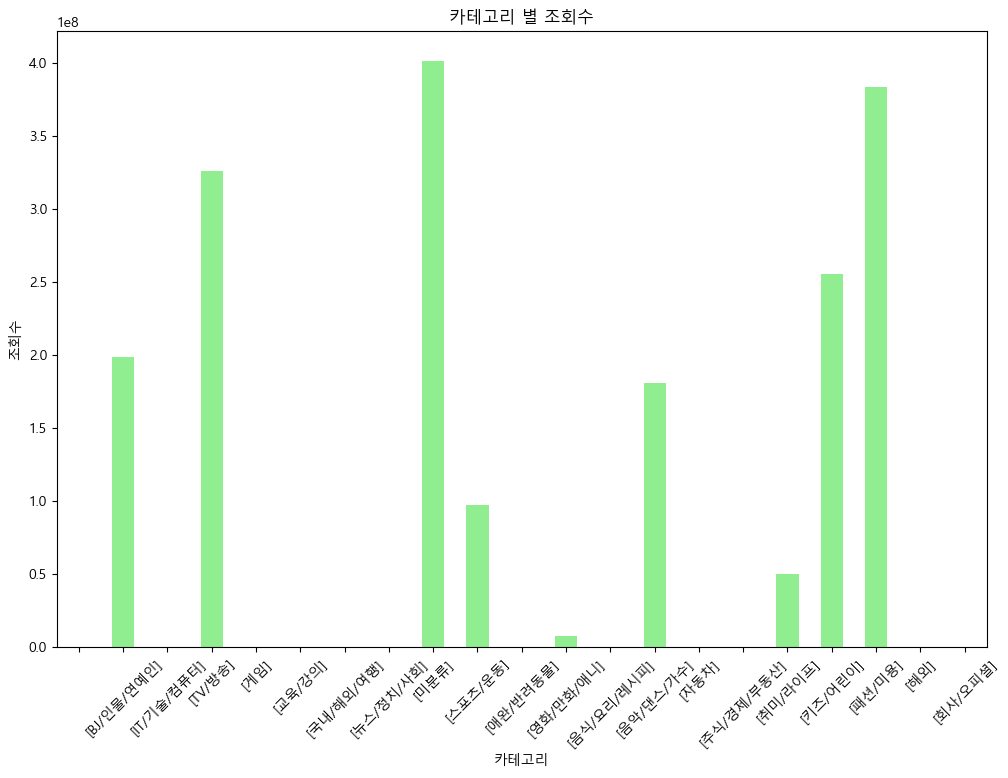

In [58]:
# 카테고리별 조회수 합계 계산
category_view_count = df.groupby('카테고리')['조회수'].sum()

# 바 차트 그리기
plt.figure(figsize=(12, 8))
category_view_count.plot(kind='bar', color='lightgreen')
plt.title('카테고리 별 조회수')
plt.xlabel('카테고리')
plt.ylabel('조회수')
plt.xticks(rotation=45)
plt.show()

In [64]:
# plotly 활용 버블 차트
fig = px.scatter(category_view_count, x='카테고리', y='조회수',
                 size='조회수', color='카테고리', hover_name='카테고리',
                 title='카테고리별 조회수',
                 size_max=60)
fig.update_layout(xaxis=dict(tickangle=-45))
fig.show()